In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import pystan
import experiments
import utils

In [2]:
import itertools
import pandas as pd
import utils
import experiments

In [3]:
rawdf = pd.read_json("PICO-annos-crowdsourcing.json", lines=True)
aggdf = pd.read_json("PICO-annos-crowdsourcing-agg.json", lines=True)
golddf = pd.read_json("PICO-annos-professional.json", lines=True)

In [4]:
userIDs = []
itemIDs = []
labels = []
golds = []
hmmcrowds = []
dawidskenes = []
majorityvotes = []
for row in rawdf.iterrows():
    itemID = row[1]["docid"]
    data = row[1]["Participants"]
    gold = golddf[golddf["docid"] == itemID]["Participants"].values[0]
    gold = gold.get("MedicalStudent")
    agg = aggdf[aggdf["docid"] == itemID]["Participants"].values[0]
    for userID, label in data.items():
        userIDs.append(userID)
        itemIDs.append(itemID)
        labels.append(label)
        golds.append(gold)
        hmmcrowds.append(agg["HMMCrowd"])
        dawidskenes.append(agg["DawidSkene"])
        majorityvotes.append(agg["MajorityVote"])
df = pd.DataFrame({"uid":userIDs, "itemID":itemIDs, "label":labels, "gold":golds,
                  "HMMCrowd":hmmcrowds, "DawidSkene":dawidskenes, "MajorityVote":majorityvotes})
df = df.sort_values("itemID")
userIdDict = utils.make_categorical(df, "uid")
itemIdDict = utils.make_categorical(df, "itemID")

In [5]:
df.shape

(1165, 7)

In [6]:
gold_labels = dict(df.groupby("itemID").first()["gold"].dropna())
hmm_labels = dict(df.groupby("itemID").first()["HMMCrowd"].dropna())
ds_labels = dict(df.groupby("itemID").first()["DawidSkene"].dropna())
mv_labels = dict(df.groupby("itemID").first()["MajorityVote"].dropna())

In [7]:
def labels2set(labels):
    ranges = [range(s[0], s[1]+1) for s in labels]
    return set(itertools.chain.from_iterable(ranges))

def list2ranges(i):
    result = []
    for a, b in itertools.groupby(enumerate(i), lambda k: k[1] - k[0]):
        b = list(b)
        result.append([b[0][1], b[-1][1]])
    return result

def intersects_per_span(a_spans, b_spans):
    a_sets = [labels2set([a]) for a in a_spans]
    b_set = labels2set(b_spans)
    scores = [len(a.intersection(b_set)) / len(a) for a in a_sets]
    return np.mean(scores)

def eval_precision(pred_spans, gold_spans):
    return intersects_per_span(pred_spans, gold_spans)

def eval_recall(pred_spans, gold_spans):
    return intersects_per_span(gold_spans, pred_spans)

def eval_f1(a_spans, b_spans):
    p = eval_precision(a_spans, b_spans)
    r = eval_precision(b_spans, a_spans)
    denom = (p + r)
    return 2 * p * r / denom if denom > 0 else 0

In [8]:
pd.set_option('display.max_colwidth', 800)

In [9]:
pd.set_option('display.width', 2000)
df.sort_values("itemID")[["label"]]

,label
1105,"[[568, 580]]"
1104,"[[21, 44], [67, 76], [362, 421], [568, 580]]"
1103,"[[67, 147]]"
1102,"[[5, 44], [61, 135], [253, 294], [362, 421], [568, 580], [659, 859], [1103, 1123]]"
1101,"[[5, 17], [395, 401]]"
1100,"[[568, 580]]"
1099,"[[21, 44], [271, 294], [362, 421], [568, 580], [1103, 1123]]"
561,"[[60, 112], [510, 518], [313, 321], [617, 625]]"
562,"[[0, 60], [60, 769]]"
563,"[[19, 25], [510, 518], [66, 73]]"


In [10]:
stan_data = utils.calc_distances(df, lambda x, y: 1 - eval_f1(x, y), "label", "itemID")

100%|██████████| 191/191 [00:03<00:00, 54.42it/s]


In [11]:
stan_data

{'items': array([  1,   1,   1, ..., 191, 191, 191]),
 'u1s': array([35, 35, 35, ..., 14, 14, 35]),
 'u2s': array([28, 14, 80, ..., 35, 84, 84]),
 'distances': array([0.7       , 1.1       , 0.85      , ..., 0.1       , 0.90645161,
        0.90645161]),
 'NDATA': 3108,
 'NITEMS': 191,
 'NUSERS': 91,
 'n_gold_users': 0,
 'gold_user_err': 0}

In [12]:
stan_model = utils.stanmodel("mas", overwrite=False)

Pickled model loaded


In [13]:

stan_data["use_diff"] = 0
stan_data["use_disc"] = 1
stan_data["use_norm"] = 1
stan_data["norm_ratio"] = 0.5
stan_data["eps_limit"] = 1
stan_data["uerr_prior_scale"] = 1
stan_data["diff_prior_scale"] = 1
stan_data["disc_prior_scale"] = 1
stan_data["DIM_SIZE"] = 8
opt = stan_model.optimizing(data=stan_data,verbose=True,iter=1500)

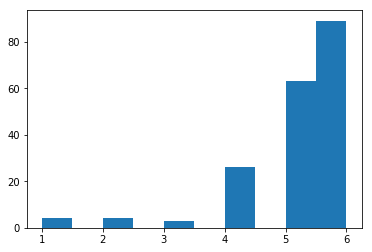

In [14]:
sddf = pd.DataFrame(stan_data)
n1 = sddf.groupby(["u1s", "items"]).count()["distances"].groupby("items").count()
plt.hist(n1)
plt.show()


In [15]:
n1.median()

5.0

In [16]:
(n1.values / 191).mean()

0.02698135682428876

In [17]:
stan_data["NUSERS"], stan_data["NITEMS"]

(91, 191)

In [18]:
opt["uerr_prior_loc"], opt["diff_prior_loc"]

(array(-0.76465438), array(-1.6402619))

In [19]:
plt.rcParams.update({'font.size': 20})

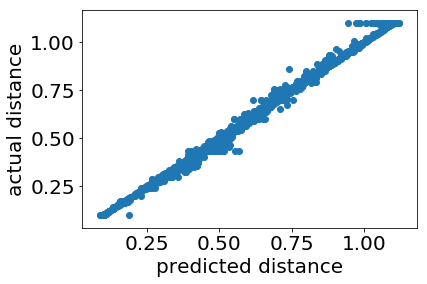

In [20]:
plt.scatter(opt["pred_distances"], stan_data["distances"])
plt.xlabel("predicted distance")
plt.ylabel("actual distance")
# plt.title("Fit Diagnostic")
plt.show()

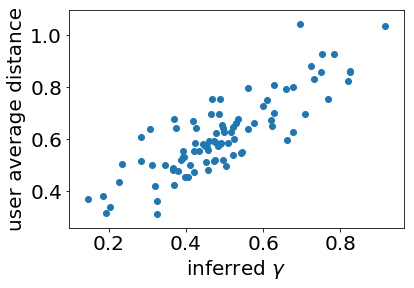

In [21]:
uerr_b = experiments.uerr_baseline(stan_data)
plt.scatter(opt["uerr"], uerr_b)
plt.xlabel("inferred $\gamma$")
plt.ylabel("user average distance")
# plt.title("User Diagnostic")
plt.show()

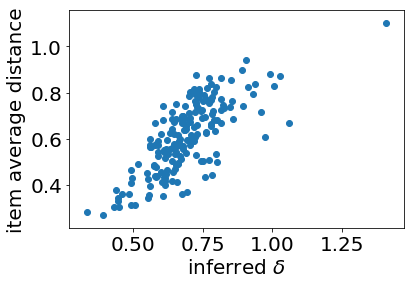

In [22]:
diff_b = sddf.groupby("items").mean()["distances"].to_dict()
diff_m = dict([(i+1, v) for i, v in enumerate(opt["disc"]) if i+1 in diff_b.keys()])
plt.scatter(diff_m.values(), diff_b.values())
plt.xlabel("inferred $\delta$")
plt.ylabel("item average distance")
# plt.title("Item Diagnostic")
plt.show()

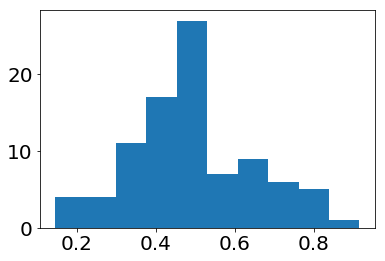

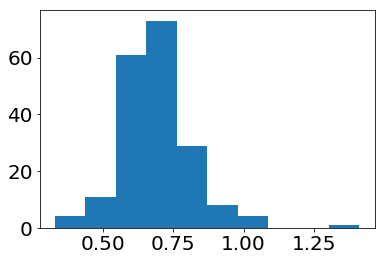

In [23]:
plt.hist(opt["uerr"])
plt.show()
plt.hist(opt["disc"])
plt.show()

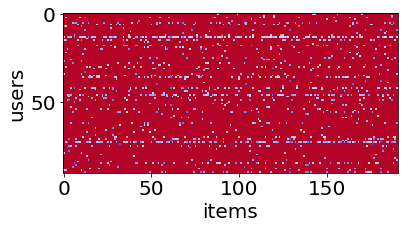

In [24]:
per_item_user_rankings = experiments.get_model_user_rankings(opt, debug=True)

In [25]:
uerr_penalties = dict(enumerate(opt["uerr"]))
idiff_penalties = dict(enumerate(opt["diff"]))

In [26]:
model4 = experiments.get_preds(df, per_item_user_rankings, "label", "itemID")

In [27]:
random = experiments.get_baseline_random(df, "label", "itemID")
faveu = experiments.get_baseline_global_best_user(stan_data, df, "label", "itemID")
center = experiments.get_baseline_item_centrallest(stan_data, df, "label", "itemID")
oracle = experiments.get_oracle_preds(stan_data, df, "label", "itemID", "worker", eval_f1, gold_labels)


In [28]:
print("MAJORITY VOTE")
experiments.eval_preds_vs(random, mv_labels, gold_labels, eval_f1)
print("FAVORITE USER")
experiments.eval_preds_vs(random, faveu, gold_labels, eval_f1)
print("SMALLEST DISTANCE")
experiments.eval_preds_vs(random, center, gold_labels, eval_f1)
print("MULTIDIMENSIONAL SCALING")
experiments.eval_preds_vs(random, model4, gold_labels, eval_f1)
print("HMM")
experiments.eval_preds_vs(random, hmm_labels, gold_labels, eval_f1)
print("ORACLE")
experiments.eval_preds_vs(random, oracle, gold_labels, eval_f1)

MAJORITY VOTE
0.5786097610032473 0.647381291455938
t-test Ttest_relResult(statistic=-4.216064276052289, pvalue=3.867398909495901e-05)
z-score 0.3083091543424553
baseline below thresh 0.0
model below thresh 0.0
FAVORITE USER
0.5786097610032473 0.660298465842276
t-test Ttest_relResult(statistic=-4.359885843372765, pvalue=2.1456990608043032e-05)
z-score 0.3188264289600761
baseline below thresh 0.0
model below thresh 0.0
SMALLEST DISTANCE
0.5786097610032473 0.6579462505193934
t-test Ttest_relResult(statistic=-4.877544353621736, pvalue=2.2897773345200433e-06)
z-score 0.3566813683260565
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL SCALING
0.5786097610032473 0.6855552123414556
t-test Ttest_relResult(statistic=-6.67830507322024, pvalue=2.680174120046809e-10)
z-score 0.48836603399542794
baseline below thresh 0.0
model below thresh 0.0
HMM
0.5786097610032473 0.6972259823199564
t-test Ttest_relResult(statistic=-6.68438825761655, pvalue=2.5918504285862783e-10)
z-score 0.488810

([0.4735202492211838,
  0.17555684271497024,
  0.5,
  1.0,
  0.578397212543554,
  0.5,
  0.6666666666666666,
  0.7499999999999999,
  0.6468085106382979,
  0.1924050632911392,
  0.5,
  0.4,
  0.6666666666666666,
  0.475110380053675,
  1.0,
  0.22876557191392977,
  0.18372093023255817,
  1.0,
  0.30028328611898014,
  1.0,
  0.4337349397590362,
  0.6666666666666666,
  0.6666666666666666,
  1.0,
  1.0,
  0.8927680798004988,
  0.30962343096234307,
  0.5434782608695652,
  0.4233576642335767,
  0.1971755928590461,
  0.8,
  0.75,
  0.4,
  0.2655442892672661,
  0.9302325581395349,
  0.3333333333333333,
  0.3316168898043254,
  0.33333333333333337,
  0.8852459016393444,
  0,
  1.0,
  0.5,
  0.5,
  0.02849002849002849,
  0,
  0.5519662695072813,
  1.0,
  0.7272727272727272,
  0.4,
  0.5714285714285715,
  1.0,
  0.4444444444444445,
  0.7272727272727273,
  0.6217006504846029,
  0.8182849936319205,
  1.0,
  0.8571428571428571,
  0.12903225806451613,
  0.6666666666666666,
  0.4,
  0.4084084084084084,


In [29]:
# def seq_agg_fn(idf, uerrs):
#     ulabels = {}
#     full_labelset = set()
#     uerr_denom = np.sum(np.exp(-uerrs.values))
#     for row in idf.iterrows():
#         labelset = labels2set(row[1]["label"])
#         ulabels[row[1]["uid"]] = labelset
#         full_labelset = full_labelset.union(labelset)
#     iscores = np.zeros(np.max(list(full_labelset)) + 1)
#     for i in full_labelset:
#         for u, val in ulabels.items():
#             if i in val:
#                 iscores[i] += np.exp(-uerrs[u+1]) / uerr_denom
#     result = list2ranges(np.where(iscores >= 0.5)[0])
#     return result

In [30]:
# model_agg50 = experiments.get_baseline_item_centrallest(stan_data, df, "label", "itemID", "uid",
#                                                 uerr_penalties, idiff_penalties, seq_agg_fn)

In [31]:
# model_agg = experiments.get_baseline_item_centrallest(stan_data, df, "label", "itemID", "uid",
#                                                 uerr_penalties, idiff_penalties, seq_agg_fn)

In [32]:
# experiments.eval_preds(mv_labels, model4, gold_labels, eval_f1)
# # experiments.eval_preds(ds_labels, model4, gold_labels, eval_f1)
# experiments.eval_preds(hmm_labels, model4, gold_labels, eval_f1)

In [33]:
random

{0: [[5, 44],
  [61, 135],
  [253, 294],
  [362, 421],
  [568, 580],
  [659, 859],
  [1103, 1123]],
 1: [[0, 60], [60, 769]],
 2: [[198, 218]],
 3: [[191, 257], [259, 313], [1440, 1487]],
 4: [[454, 485], [948, 972]],
 5: [[372, 406]],
 6: [[341, 435]],
 7: [[85, 108], [111, 160], [347, 388], [419, 474], [1590, 1611]],
 8: [[29, 58], [129, 177], [189, 215]],
 9: [[220, 257]],
 10: [[313, 363]],
 11: [[231, 289]],
 12: [[201, 221]],
 13: [[67, 109], [506, 514], [609, 655]],
 14: [[349, 390]],
 15: [[258, 837]],
 16: [[78, 311], [357, 368], [854, 876]],
 17: [[55, 112], [606, 617]],
 18: [[249, 389]],
 19: [[55, 100], [183, 218]],
 20: [[1071, 1225], [1426, 1465]],
 21: [[220, 293]],
 22: [[307, 415]],
 23: [[17, 33], [221, 248]],
 24: [[126, 142], [242, 268], [324, 345], [1181, 1204]],
 25: [[45, 62], [188, 224], [266, 277], [428, 465]],
 26: [[19, 36], [155, 206], [611, 641]],
 27: [[0, 98], [98, 176], [222, 276], [296, 362], [673, 696]],
 28: [[337, 361], [1973, 2012]],
 29: [[70, 98]

In [34]:
baseline

NameError: name 'baseline' is not defined

In [ ]:
model

In [ ]:
gold_labels

In [ ]:
def compare(d1, d2, g):
    result = {}
    for key, value in d1.items():
        result[str(key)+"A"] = value
    for key, value in d2.items():
        result[str(key)+"B"] = value
    for key, value in g.items():
        result[str(key)+"G"] = value
    for key in sorted(result):
        print(key, result[key])

In [ ]:
experiments.eval_preds(model_agg, model_agg50, gold_labels, eval_f1, True)